In [99]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

from sklearn.preprocessing import MultiLabelBinarizer


# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [101]:
# # # load the data from the xlsx file
from pathlib import Path
import time


# # #  time this read operation

# # start = time.time()
p  = Path('/Users/david/projects/lc-project-data/2024-10-12')
fn = "2024-10-12.xlsx"
# df = pd.read_excel(str(p / fn), header = 0, engine='openpyxl')
# # finish = time.time()
# # print(f"Time taken to read {fn}: {finish - start:.2f}s")

# df.shape

# # # NOTE: takes about 26 [s] to load! need to save as a more efficient format

In [102]:
# # save the preserved_df to a 

# import pyarrow as pa
# import pyarrow.parquet as pq

# table = pa.Table.from_pandas(df, preserve_index=True)
# pq.write_table(table, 'preserved_df.parquet')

In [103]:
# # convert all object dtypes to string

# for col in df.columns:
#     if df[col].dtype == 'object':
#         df[col] = df[col].astype(str)


# # save as a parquet file for future use
# df.to_parquet(p / '2024-10-12.parquet')

In [104]:
# time the loading of the parquet file
import time
start = time.time()
df = pd.read_parquet(p / '2024-10-12.parquet')
finish = time.time()
print(f"Time taken to read parquet file: {finish - start:.2f}s")
print(df.shape)

Time taken to read parquet file: 0.09s
(6121, 788)


# LOAD AND GENERATE TIME BINS

In [105]:
# # read the time bins from the second worksheet

# df_time_bins = pd.read_excel(str(p / fn), 
#                                 sheet_name = 1,
#                                 header = 0, 
#                                 engine='openpyxl')

In [106]:
# # in the time bins, we need to keep the record_id, CONFIRMED_months, and LCN_LCP_HC_ORIGIINAL columns
# df_time_bins = df_time_bins[['record_id', 'CONFIRMED_Months', 'LCN_LCP_HC_ORIGINAL']]


# # rename the columns: record_id, months, and LC_STATUS
# df_time_bins.columns = ['record_id', 'months', 'LC_STATUS']

# df_time_bins

In [107]:
# # how many nans in months?
# df_time_bins.months.isna().sum()

In [108]:
# # how manmy empty values are there in the months col?
# df_time_bins.months.isna().sum()

# # drop these rows
# df_time_bins = df_time_bins.dropna(subset = ['months'])


# # round the months up to the next highest integer
# df_time_bins['Months_Rounded'] = df_time_bins['months'].apply(np.ceil).astype(int)


# # bin the months
# bins = [3, 6, 12, 24, 36, 1000]
# labels = ['3-6', '6-12', '12-24', '24-36', '>36']
# labels = [1,2,3,4,5]

# months_binned = pd.cut(df_time_bins["Months_Rounded"], 
#                        bins = bins, 
#                        labels = labels, 
#                        right = False)

# # rename the column
# months_binned = months_binned.rename("Months_Binned")

# # add record_id
# df_time_bins = pd.concat([df_time_bins, months_binned], axis = 1)


# # add bin labels
# df_time_bins["Bin_Labels"] = df_time_bins["Months_Binned"].map({1: '3-6', 
#                                                                 2: '6-12', 
#                                                                 3: '12-24',
#                                                                 4: '24-36',
#                                                                 5: '>36'}
#                                                             )
# df_time_bins


In [109]:
# # convert all object dtypes to string

# for col in df_time_bins.columns:
#     if df_time_bins[col].dtype == 'object':
#         df_time_bins[col] = df_time_bins[col].astype(str)


# # save as a parquet file for future use
# df_time_bins.to_parquet(p / '2024-10-12-time-bins.parquet')

In [110]:
# load from the parquet file
df_time_bins = pd.read_parquet(p / '2024-10-12-time-bins.parquet')

In [111]:
df_time_bins

,record_id,months,LC_STATUS,Months_Rounded,Months_Binned,Bin_Labels
0,1,7.293035,1,8,2,6-12
1,2,8.771353,1,9,2,6-12
2,3,8.738502,1,9,2,6-12
3,4,33.442838,1,34,4,24-36
4,5,36.169514,1,37,5,>36
...,...,...,...,...,...,...
5556,5714,39.881735,0,40,5,>36
5557,5715,49.507227,0,50,5,>36
5558,5716,48.357424,0,49,5,>36
5559,5717,27.595269,0,28,4,24-36


In [112]:
# how many missing values are there in months column?
df_time_bins.months.isna().sum()

0

# JOIN DATA

In [113]:
df.shape, df_time_bins.shape

((6121, 788), (3946, 6))

In [114]:
# group by Bin_Label and LC_STATUS
grouped = df_time_bins.groupby(["Bin_Labels", "LC_STATUS"]).size().reset_index(name = "Count")
grouped

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/3484988751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_time_bins.groupby(["Bin_Labels", "LC_STATUS"]).size().reset_index(name = "Count")


,Bin_Labels,LC_STATUS,Count
0,3-6,0,1121
1,3-6,1,440
2,6-12,0,1100
3,6-12,1,561
4,12-24,0,185
5,12-24,1,234
6,24-36,0,40
7,24-36,1,193
8,>36,0,31
9,>36,1,41


In [115]:
df.head()

,record_id,sex,gender,age,home_location,living_with,country,employed,occupation,occupation2,...,datetime_freezing,aliquots,biospecimen_collection_not,biospecimen_used___1,biospecimen_used_2_Paper_1,matchnumber,lc_status,LCN_LCP_HC_ORIGINAL,sample_label_id,biospecimen_complete
0,1,1.0,MALE,47.0,1.0,3.0,42,1.0,Engineering Technologist,7.0,...,2023-12-15 15:36:00,H,"Sample lipemic TV = 6 x 250uL (A-F), 2 x 500u...",1,1,NaN,1,1.0,LDN-0001,2
1,2,2.0,nan,37.0,1.0,1.0,16,0.0,nan,NaN,...,2023-12-18 08:56:00,H,4 x 250uL (A-D) 4 x 500uL (E-H),1,1,NaN,1,1.0,LDN-0002,2
2,3,2.0,FEMALE,54.0,1.0,1.0,16,1.0,Administrator,3.0,...,2023-12-18 09:05:00,H,5 x 250uL (A-E) 3 x 500uL (F-H),1,1,NaN,1,1.0,LDN-0003,2
3,4,1.0,nan,78.0,1.0,1.0,62,0.0,nan,NaN,...,2024-01-05 14:28:00,G,nan,1,1,NaN,1,1.0,LDN-0004,2
4,5,2.0,FEMALE,33.0,1.0,1.0,16,1.0,Nurse,11.0,...,2024-01-05 14:55:00,G,"No Sample ""E""",1,1,NaN,1,1.0,LDN-0005,2


In [116]:
# join df and df_time_bins on record_id
df = df.merge(df_time_bins, on = "record_id", how = "inner")
df.shape

(3946, 793)

In [117]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = deepcopy(df)
preserved_df.shape

(3946, 793)

In [118]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

# SYMPTOMS

In [119]:
# read the list of symtpoms from the json file
import json
with open("../OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP + ["record_id"]]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns if col != "record_id"] + ["record_id"]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1)

symptom_features.shape

(3946, 57)

In [120]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
# df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


<Axes: >

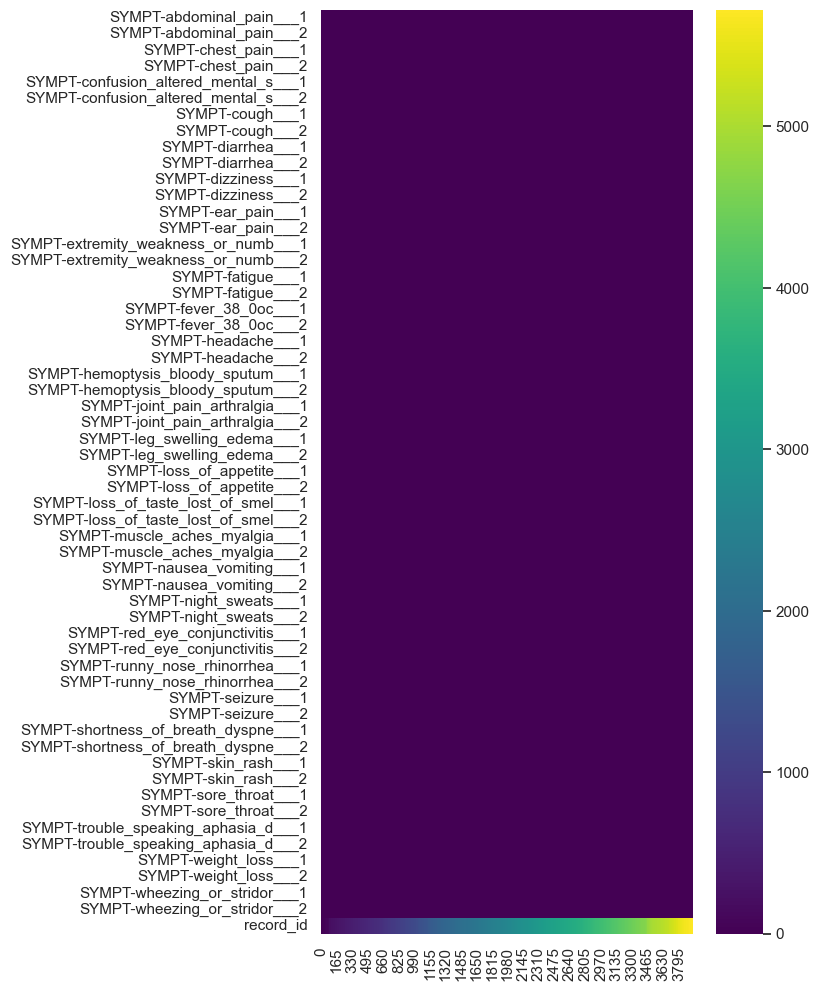

In [121]:
fig, ax = plt.subplots(figsize=(6,12))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## TIME SERIES


In [189]:
# set index to record_id
try:
    df_time_bins = df_time_bins.set_index('record_id')
    # set index to record_id
    symptom_features = symptom_features.set_index('record_id')
except KeyError:
    pass


# concatenate symptoms and df_time_bins
symptoms_time_bins = symptom_features.join(df_time_bins)

# add in dag from df
symptoms_time_bins = symptoms_time_bins.join(df.set_index('record_id')['dag'])

In [190]:
symptoms_time_bins.shape
symptoms_time_bins

,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,SYMPT-cough___2,SYMPT-diarrhea___1,SYMPT-diarrhea___2,...,SYMPT-weight_loss___1,SYMPT-weight_loss___2,SYMPT-wheezing_or_stridor___1,SYMPT-wheezing_or_stridor___2,months,LC_STATUS,Months_Rounded,Months_Binned,Bin_Labels,dag
record_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,1,1,0,0,...,0,0,1,1,7.293035,1,8,2,6-12,1
1,0,0,0,0,1,0,1,1,1,0,...,1,1,1,1,7.293035,1,8,2,6-12,1
3,0,0,0,0,1,1,1,1,0,0,...,1,0,0,0,8.738502,1,9,2,6-12,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,33.442838,1,34,4,24-36,1
5,0,0,1,0,1,1,1,1,1,0,...,1,0,1,0,36.169514,1,37,5,>36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5714,0,0,1,0,1,0,1,0,1,1,...,1,0,0,0,39.881735,0,40,5,>36,3
5715,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,49.507227,0,50,5,>36,3
5716,0,0,1,1,0,0,0,0,1,1,...,0,0,1,1,48.357424,0,49,5,>36,3


In [191]:
# select only LC+ records
lc_plus = symptoms_time_bins[symptoms_time_bins.LC_STATUS == 1]
lc_plus.shape

(1469, 62)

In [198]:
lc_plus

,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,SYMPT-cough___2,SYMPT-diarrhea___1,SYMPT-diarrhea___2,...,SYMPT-weight_loss___1,SYMPT-weight_loss___2,SYMPT-wheezing_or_stridor___1,SYMPT-wheezing_or_stridor___2,months,LC_STATUS,Months_Rounded,Months_Binned,Bin_Labels,dag
record_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,1,1,0,0,...,0,0,1,1,7.293035,1,8,2,6-12,1
1,0,0,0,0,1,0,1,1,1,0,...,1,1,1,1,7.293035,1,8,2,6-12,1
3,0,0,0,0,1,1,1,1,0,0,...,1,0,0,0,8.738502,1,9,2,6-12,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,33.442838,1,34,4,24-36,1
5,0,0,1,0,1,1,1,1,1,0,...,1,0,1,0,36.169514,1,37,5,>36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,37.877792,1,38,5,>36,3
5639,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,44.809461,1,45,5,>36,3
5640,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,17.509855,1,18,3,12-24,3


In [225]:
zz = lc_plus.groupby(['dag','Bin_Labels']).mean().fillna(0)

# apply site labels to index
zz.index = zz.index.set_levels(zz.index.levels[0].map(site_name_dict), level=0)

# drop any col with Months 
zz = zz.drop('Months_Binned', axis = 1)
zz = zz.drop('Months_Rounded', axis = 1)
zz = zz.drop('LC_STATUS', axis = 1)


# map columns to symptom names
# zz.columns = zz.columns.map(nice_feature_names)
# style zz with a colour map
styler = zz.style.background_gradient(cmap='viridis', axis = 0)

styler

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/2341014774.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zz = lc_plus.groupby(['dag','Bin_Labels']).mean().fillna(0)


In [228]:
styler.to_excel('lc_plus_symptoms.xlsx')

<Axes: xlabel='dag-Bin_Labels'>

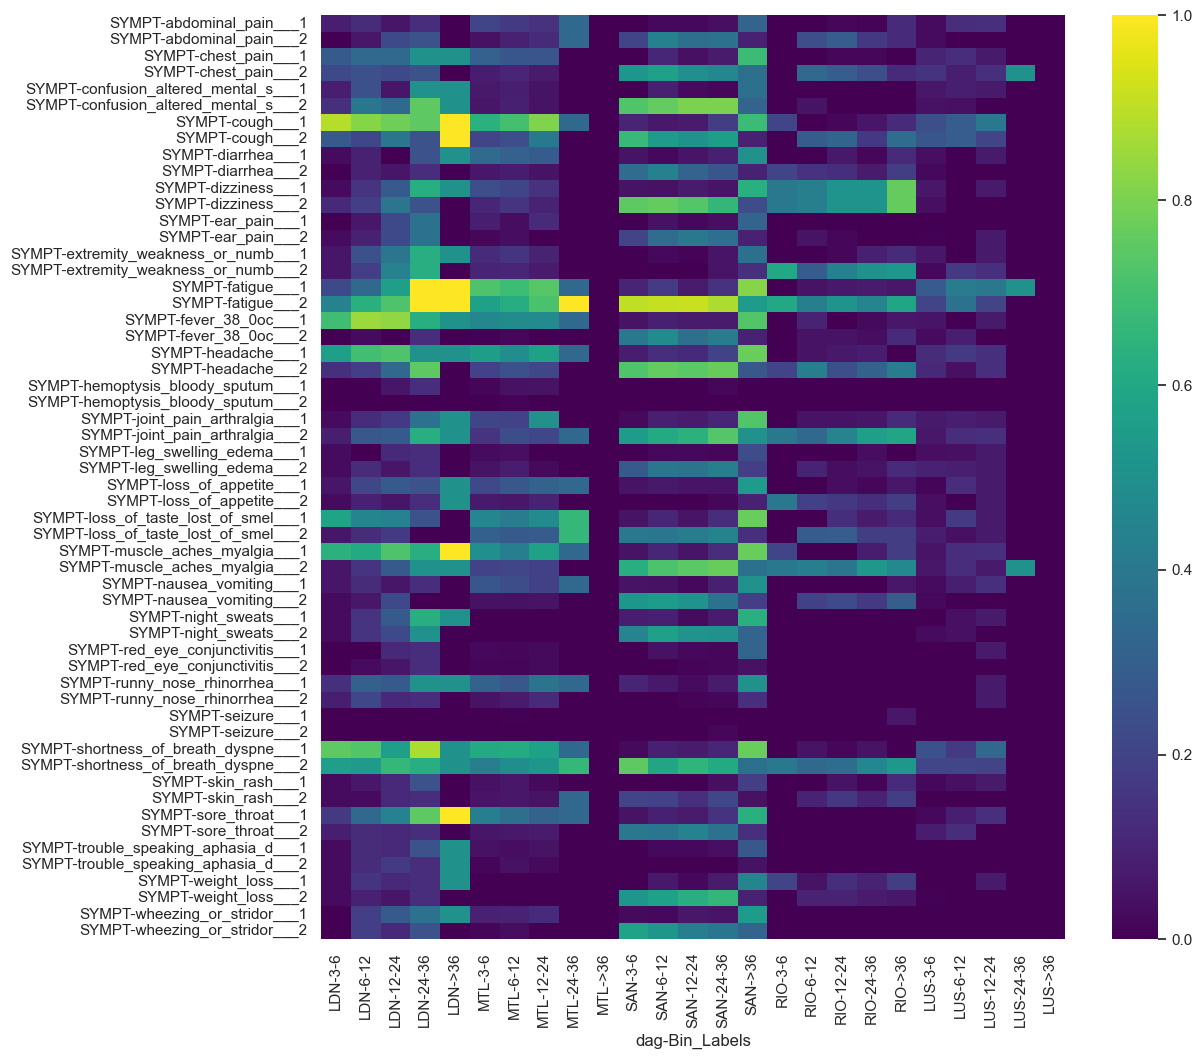

In [226]:
# heatmap of zz
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(zz.T, cbar=True, ax = ax, cmap = 'viridis')


In [223]:
# load nice fdeature names from ../JSON/nice-features.csv
nice_features = pd.read_csv("../JSON/niceFeatures.csv", header = 0)
# make a dict
nice_features_dict = nice_features.set_index("feature").to_dict()["clean"]
nice_features_dict

{'CD-adjunctive___1': 'CoV Vasopressor/Inotrope',
 'CD-difficulty_with_concentrat___4': 'LC+ Concentration Unknown Origin',
 'CD-hospitalized': 'CoV Hospitalized',
 'CD-medication_received___1': 'CoV Steroids',
 'CD-medication_received___2': 'CoV Remdesivir',
 'CD-medication_received___3': 'CoV Anticoagulant',
 'CD-medication_received___4': 'CoV Colchicine',
 'CD-medication_received___5': 'CoV Antibiotics',
 'CD-medication_received___6': 'CoV Other Meds',
 'CD-memory_problems___4': 'LC+ Memory Unknown Origin',
 'CD-required_oxygen': 'CoV Oxygen',
 'CD-respiratory-other-4': 'LC+ Respiratory Unknown Origin',
 'CD-severity_level___0': 'CoV UnInfected',
 'CD-severity_level___1': 'CoV Mild',
 'CD-severity_level___2': 'CoV Moderate',
 'CD-severity_level___3': 'CoV Severe',
 'CD-spo2': 'CoV SpO2',
 'CD-type_of_care___1': 'CoV ICU',
 'CD-type_of_care___2': 'CoV Non-ICU',
 'CD-anxiety___1': 'CoV Anxiety',
 'CD-anxiety___2': 'LC+ Anxiety',
 'CD-insomnia___1': 'CoV Insomnia',
 'CD-insomnia___2': 

In [196]:
alist = [
    'SYMPT-fatigue___1',
    'SYMPT-shortness_of_breath_dyspne___1',
    'SYMPT-cough___1',
    'SYMPT-headache___1',
    'SYMPT-loss_of_taste_lost_of_smel___1',
    'SYMPT-muscle_aches_myalgia___1',
    'SYMPT-joint_pain_arthralgia___1',
    'SYMPT-dizziness___1',
    'SYMPT-chest_pain___1',
    'SYMPT-extremity_weakness_or_numb___1',
]
blist = [
    'SYMPT-fatigue___2',
    'SYMPT-shortness_of_breath_dyspne___2',
    'SYMPT-cough___2',
    'SYMPT-headache___2',
    'SYMPT-loss_of_taste_lost_of_smel___2',
    'SYMPT-muscle_aches_myalgia___2',
    'SYMPT-joint_pain_arthralgia___2',
    'SYMPT-dizziness___2',
    'SYMPT-chest_pain___2',
    'SYMPT-extremity_weakness_or_numb___2',
]

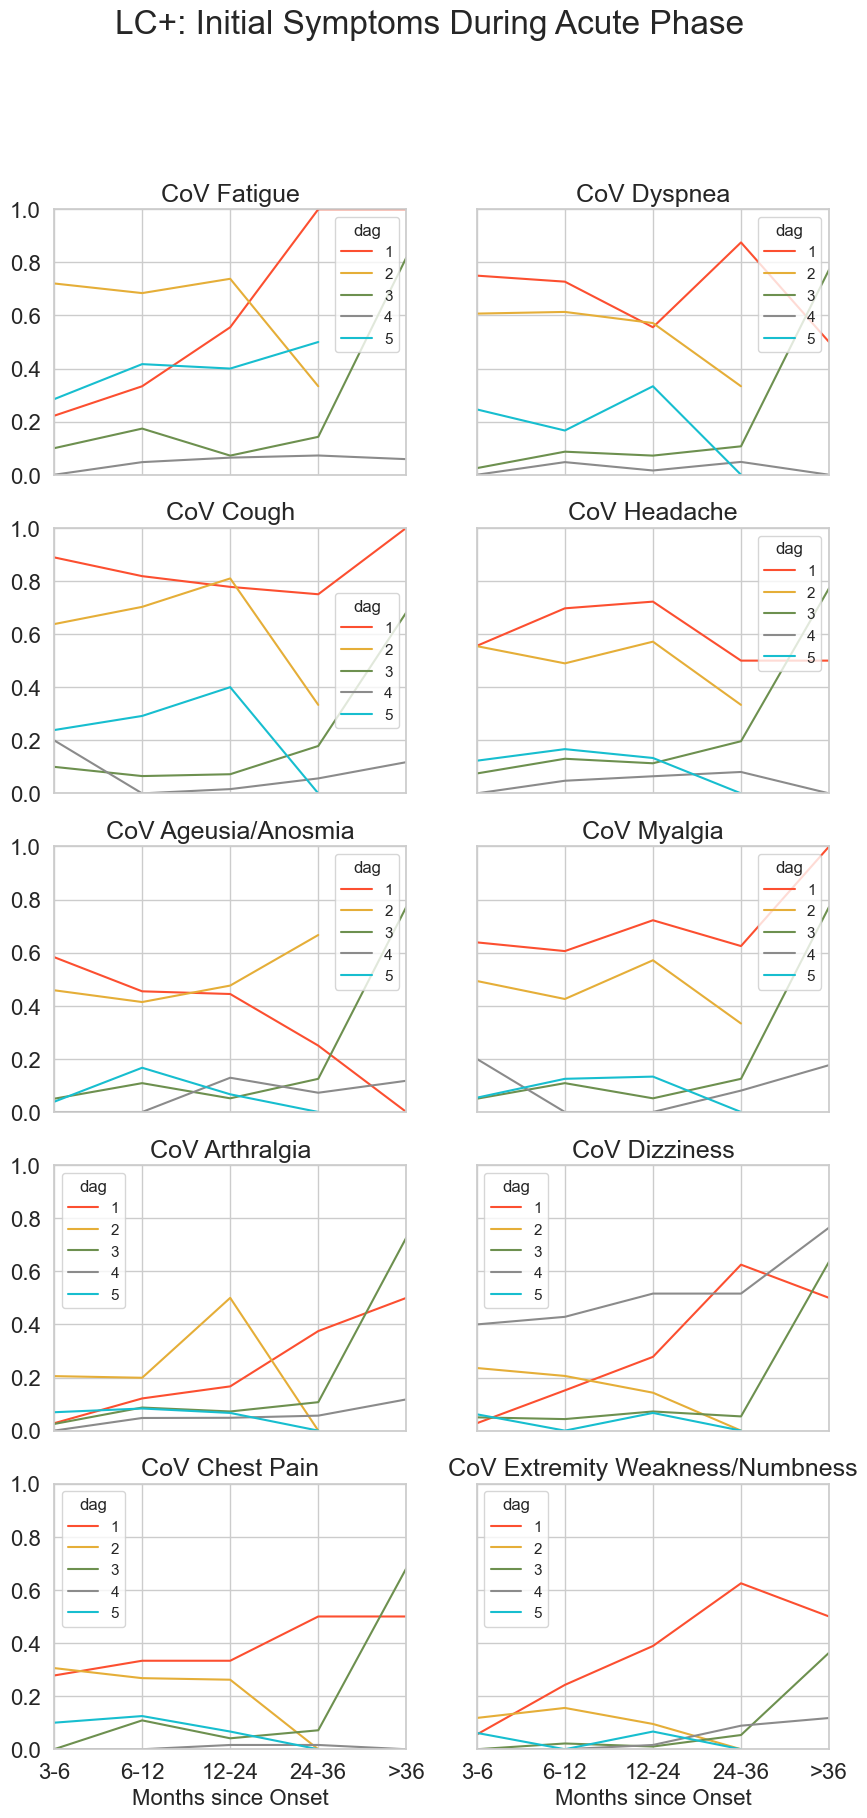

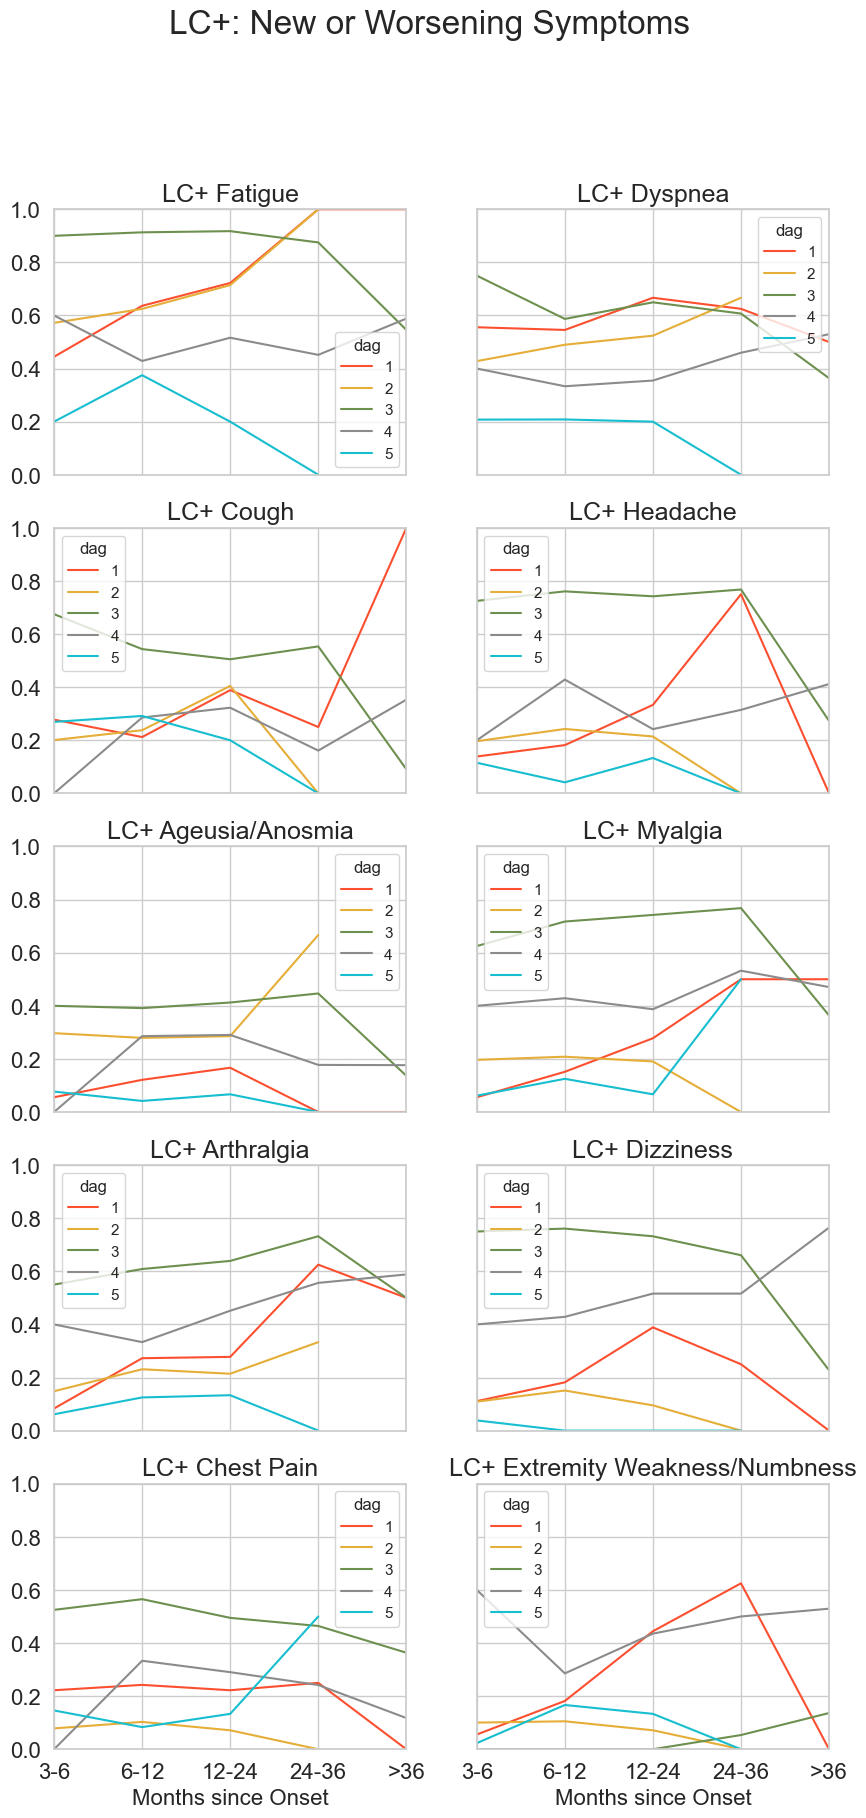

In [202]:
# make a box plot with bin on the x-axis and symptoms on the y-axis

sympts = [col for col in lc_plus.columns if col.startswith("SYMPT-")]

# subselect sympts that end with ___1
sympts1 = [s for s in sympts if s.endswith("_1")]
sympts2 = [s for s in sympts if s.endswith("_2")]

sympts1 = alist
sympts2 = blist

for sympt_set in [sympts1, sympts2]:
    fig, ax = plt.subplots(5,2, figsize=(10, 20), sharex = True, sharey = True)

    # put a little space between the plots
    plt.subplots_adjust(wspace = 0.20)

    ax = ax.flatten()

    for j,s in enumerate(sympt_set):
        # fig, ax = plt.subplots(figsize=(10, 8))

        sns.lineplot(data = lc_plus, 
                    x = "Bin_Labels", 
                    y = s, 
                    hue = "dag",
                    palette = palette_dict,
                    errorbar = None,
                    ax = ax[j])

        # map the symptom to the nice name

        s2 = nice_features_dict[s]

        ax[j].set_title(s2, fontsize = 18)


        # turn off axis title
        ax[j].set_xlabel('Months since Onset', fontsize = 16)
        ax[j].set_ylabel('')

        # make all fonts bigger
        ax[j].tick_params(axis='both', which='major', labelsize=16)
        ax[j].tick_params(axis='both', which='minor', labelsize=16)



    suptitle = "LC+: Initial Symptoms During Acute Phase" if sympt_set == sympts1 else "LC+: New or Worsening Symptoms"
    fig.suptitle(suptitle, fontsize = 24)


    # plt.tight_layout()

    # x limits
    plt.xlim(0, 3)
    plt.ylim(0, 1)


    # lowercase, remove white space and punt from suptitle
    suptitle = suptitle.lower().replace(" ", "_").replace(":", "")

    fn = f"symptoms_{suptitle}.png"

    plt.savefig(fn, dpi = 600)
    plt.show()
    plt.close()


# # plot the symptoms

# fig, ax = plt.subplots(7,8, figsize=(20, 20), sharex = True, sharey = True)

# ax = ax.flatten()


# for j,s in enumerate(sympts):
#     # fig, ax = plt.subplots(figsize=(10, 8))

#     sns.lineplot(data = lc_plus, 
#                 x = "Bin_Labels", 
#                 y = s, 
#                 ax = ax[j],
#                 #  err_style = "bars",
#                 errorbar = ("ci", 95),)

#     ax[j].set_title(s)

In [130]:
# calculate the mean of each symptom by bin and LC_STATUS
qq= symptoms_time_bins.groupby(["LC_STATUS", "Bin_Labels"], 
                               observed = True, dropna = True).mean(numeric_only = True, )

# drop cols that don't start with SYMPT
qq = qq.loc[:, qq.columns.str.startswith("SYMPT")]

# convert qq from wide to long format
qq = qq.reset_index().melt(id_vars = ["LC_STATUS", "Bin_Labels"], 
                           var_name = "Symptom", 
                           value_name = "Prevalence")


# drop all rows that are months_rounded
qq = qq[~qq["Symptom"].str.contains("Months")]

# add a column based on the value in symptom.
# if the item in SYMPTOM ends with __1, it is an initial symptom
# if the item in SYMPTOM ends with __2, it is a follow-up symptom
qq['Symptom_Type'] = qq['Symptom'].apply(lambda x: 'Initial' if x.endswith('__1') else 'Current')

# rename the symptoms by droppoing the __1 or __2
qq['Symptom'] = qq['Symptom'].str.replace('___1', '').str.replace('___2', '')


# map LC_STATUS to a string
qq['LC_STATUS'] = qq['LC_STATUS'].map({0: 'LC-', 1: 'LC+'})


qq["Full Status"] = qq["LC_STATUS"] + " " + qq["Symptom_Type"]
qq

,LC_STATUS,Bin_Labels,Symptom,Prevalence,Symptom_Type,Full Status
0,LC-,3-6,SYMPT-abdominal_pain,0.042819,Initial,LC- Initial
1,LC-,6-12,SYMPT-abdominal_pain,0.102727,Initial,LC- Initial
2,LC-,12-24,SYMPT-abdominal_pain,0.032432,Initial,LC- Initial
3,LC-,24-36,SYMPT-abdominal_pain,0.100000,Initial,LC- Initial
4,LC-,>36,SYMPT-abdominal_pain,0.064516,Initial,LC- Initial
...,...,...,...,...,...,...
555,LC+,3-6,SYMPT-wheezing_or_stridor,0.059091,Current,LC+ Current
556,LC+,6-12,SYMPT-wheezing_or_stridor,0.078431,Current,LC+ Current
557,LC+,12-24,SYMPT-wheezing_or_stridor,0.183761,Current,LC+ Current
558,LC+,24-36,SYMPT-wheezing_or_stridor,0.124352,Current,LC+ Current


In [131]:
# how many unique values of Symptom are there?
qq.Symptom.nunique()

28

In [132]:
# # drop rows where LC_STATUS is LC- and Symptom_Type is Current
# qq = qq[~((qq["LC_STATUS"] == "LC-") & (qq["Symptom_Type"] == "Current"))]
# qq.shape

In [133]:
qq

,LC_STATUS,Bin_Labels,Symptom,Prevalence,Symptom_Type,Full Status
0,LC-,3-6,SYMPT-abdominal_pain,0.042819,Initial,LC- Initial
1,LC-,6-12,SYMPT-abdominal_pain,0.102727,Initial,LC- Initial
2,LC-,12-24,SYMPT-abdominal_pain,0.032432,Initial,LC- Initial
3,LC-,24-36,SYMPT-abdominal_pain,0.100000,Initial,LC- Initial
4,LC-,>36,SYMPT-abdominal_pain,0.064516,Initial,LC- Initial
...,...,...,...,...,...,...
555,LC+,3-6,SYMPT-wheezing_or_stridor,0.059091,Current,LC+ Current
556,LC+,6-12,SYMPT-wheezing_or_stridor,0.078431,Current,LC+ Current
557,LC+,12-24,SYMPT-wheezing_or_stridor,0.183761,Current,LC+ Current
558,LC+,24-36,SYMPT-wheezing_or_stridor,0.124352,Current,LC+ Current


In [134]:
# find rows in qq that contain fatigue
qq[qq["Symptom"].str.contains("fatigue")].groupby(["LC_STATUS", "Symptom_Type"]).mean(numeric_only = True)




Prevalence
LC_STATUS Symptom_Type            
LC+       Current         0.602582
          Initial         0.394554
LC-       Current         0.109530
          Initial         0.608897

In [135]:
qq

,LC_STATUS,Bin_Labels,Symptom,Prevalence,Symptom_Type,Full Status
0,LC-,3-6,SYMPT-abdominal_pain,0.042819,Initial,LC- Initial
1,LC-,6-12,SYMPT-abdominal_pain,0.102727,Initial,LC- Initial
2,LC-,12-24,SYMPT-abdominal_pain,0.032432,Initial,LC- Initial
3,LC-,24-36,SYMPT-abdominal_pain,0.100000,Initial,LC- Initial
4,LC-,>36,SYMPT-abdominal_pain,0.064516,Initial,LC- Initial
...,...,...,...,...,...,...
555,LC+,3-6,SYMPT-wheezing_or_stridor,0.059091,Current,LC+ Current
556,LC+,6-12,SYMPT-wheezing_or_stridor,0.078431,Current,LC+ Current
557,LC+,12-24,SYMPT-wheezing_or_stridor,0.183761,Current,LC+ Current
558,LC+,24-36,SYMPT-wheezing_or_stridor,0.124352,Current,LC+ Current


/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/2067110048.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = qq,
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/2067110048.py:7: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.lineplot(data = qq,


Text(0.5, 1.0, 'Symptom Prevalence by Bin and LC_STATUS')

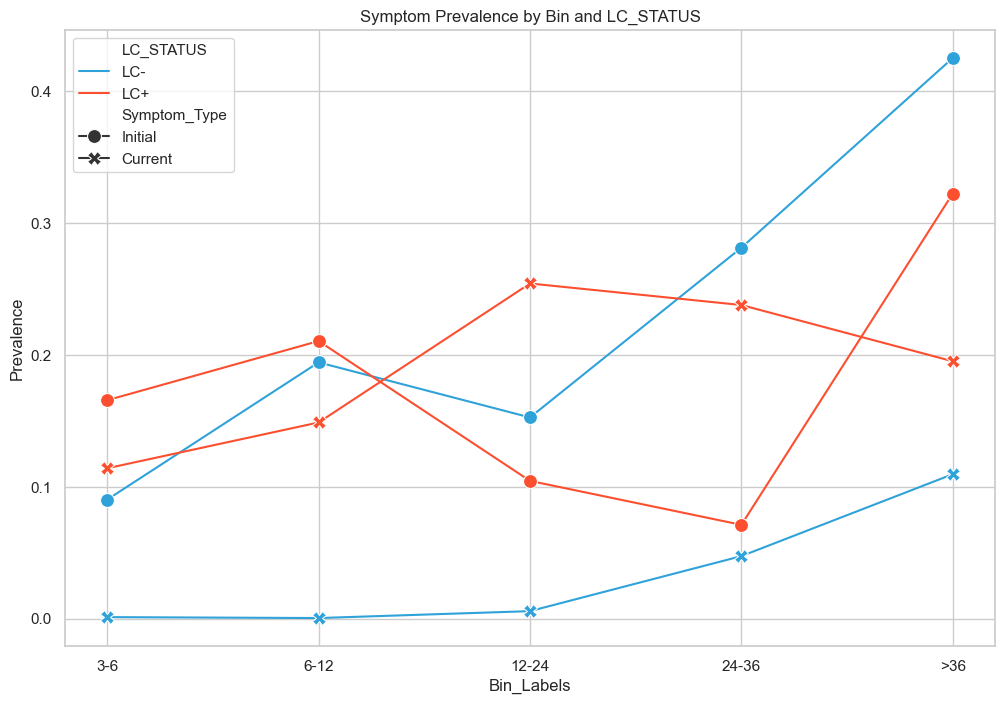

In [136]:
# plot a series of lines, one for each symptom, showing the prevalence of each symptom by bin and LC_STATUS
plt.figure(figsize = (12, 8))




sns.lineplot(data = qq, 
             x = "Bin_Labels", 
             y = "Prevalence", 
             hue = "LC_STATUS", 
            #  hue_order = ['LC- Initial', 'LC- Current', 'LC+ Initial', 'LC+ Current'],
             style = "Symptom_Type", 
             markers = True, 
             dashes = False, 
             palette = cc.glasbey_hv,
            #  palette = ["blue", "red"], 
             markersize = 10,
             # show error using the min and max values
                ci = None
                # err_style = "band",
                # err_kws = {"alpha": 0.2},


             )

plt.title("Symptom Prevalence by Bin and LC_STATUS")

In [137]:
# heatmap
# fig, ax = plt.subplots(figsize=(12, 12))

# map bin_labels to integers
bin_labels = {"3-6": 1, "6-12": 2, "12-24": 3, "24-36": 4, ">36": 5}

qq["Bin_Labels_INT"] = qq["Bin_Labels"].map(bin_labels)


# pivot table
qq_pivot = qq.pivot_table(index = ["Symptom", "Symptom_Type", "LC_STATUS"], columns = "Bin_Labels_INT", values = "Prevalence", aggfunc = 'mean')
qq_pivot

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/3965494389.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  qq_pivot = qq.pivot_table(index = ["Symptom", "Symptom_Type", "LC_STATUS"], columns = "Bin_Labels_INT", values = "Prevalence", aggfunc = 'mean')


Bin_Labels_INT                                           1         2  \
Symptom                   Symptom_Type LC_STATUS                       
SYMPT-abdominal_pain      Current      LC+        0.050000  0.119430   
                                       LC-        0.000000  0.000000   
                          Initial      LC+        0.122727  0.146168   
                                       LC-        0.042819  0.102727   
SYMPT-chest_pain          Current      LC+        0.150000  0.156863   
...                                                    ...       ...   
SYMPT-weight_loss         Initial      LC-        0.000000  0.002727   
SYMPT-wheezing_or_stridor Current      LC+        0.059091  0.078431   
                                       LC-        0.000000  0.000000   
                          Initial      LC+        0.050000  0.085561   
                                       LC-        0.020517  0.048182   

Bin_Labels_INT                                           3         4         5  
Symptom                   Symptom_Type LC_STATUS                                
SYMPT-abdominal_pain      Current      LC+        0.264957  0.227979  0.097561  
                                       LC-        0.000000  0.000000  0.032258  
                          Initial      LC+        0.051282  0.025907  0.219512  
                                       LC-        0.032432  0.100000  0.064516  
SYMPT-chest_pain          Current      LC+        0.320513  0.305699  0.243902  
...                                                    ...       ...       ...  
SYMPT-weight_loss         Initial      LC-        0.010811  0.200000  0.419355  
SYMPT-wheezing_or_stridor Current      LC+        0.183761  0.124352  0.170732  
                                       LC-        0.005405  0.075000  0.161290  
                          Initial      LC+        0.068376  0.031088  0.317073  
                                       LC-        0.037838  0.100000  0.419355  

[112 rows x 5 columns]

In [138]:
# # two heatmaps side bys side, one for initial and one for current

# fig, ax = plt.subplots(1, 2, figsize=(12, 12), sharey = True)

# sns.heatmap(qq_pivot.loc[(slice(None), "Initial"), :], ax = ax[0], cmap = 'viridis', cbar = False)
# ax[0].set_title("Initial Symptoms")

# sns.heatmap(qq_pivot.loc[(slice(None), "Current"), :], ax = ax[1], cmap = 'viridis', cbar = False)
# ax[1].set_title("Current Symptoms")


# # turn  off y-axis labels
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')

# # set yticks to be the symptom names
# # ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation = 0)


In [139]:
# TODO

# - [x] add the record_id to the features for better indexing
# - [x] group by symptom_state: initial == 1, follow-up == 2
# - [ ] plot a seriews of lines

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/137695387.py:6: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.barplot(data = qq, y = "Symptom", x = "Prevalence", hue = "Full Status",


<Axes: xlabel='Prevalence', ylabel='Symptom'>

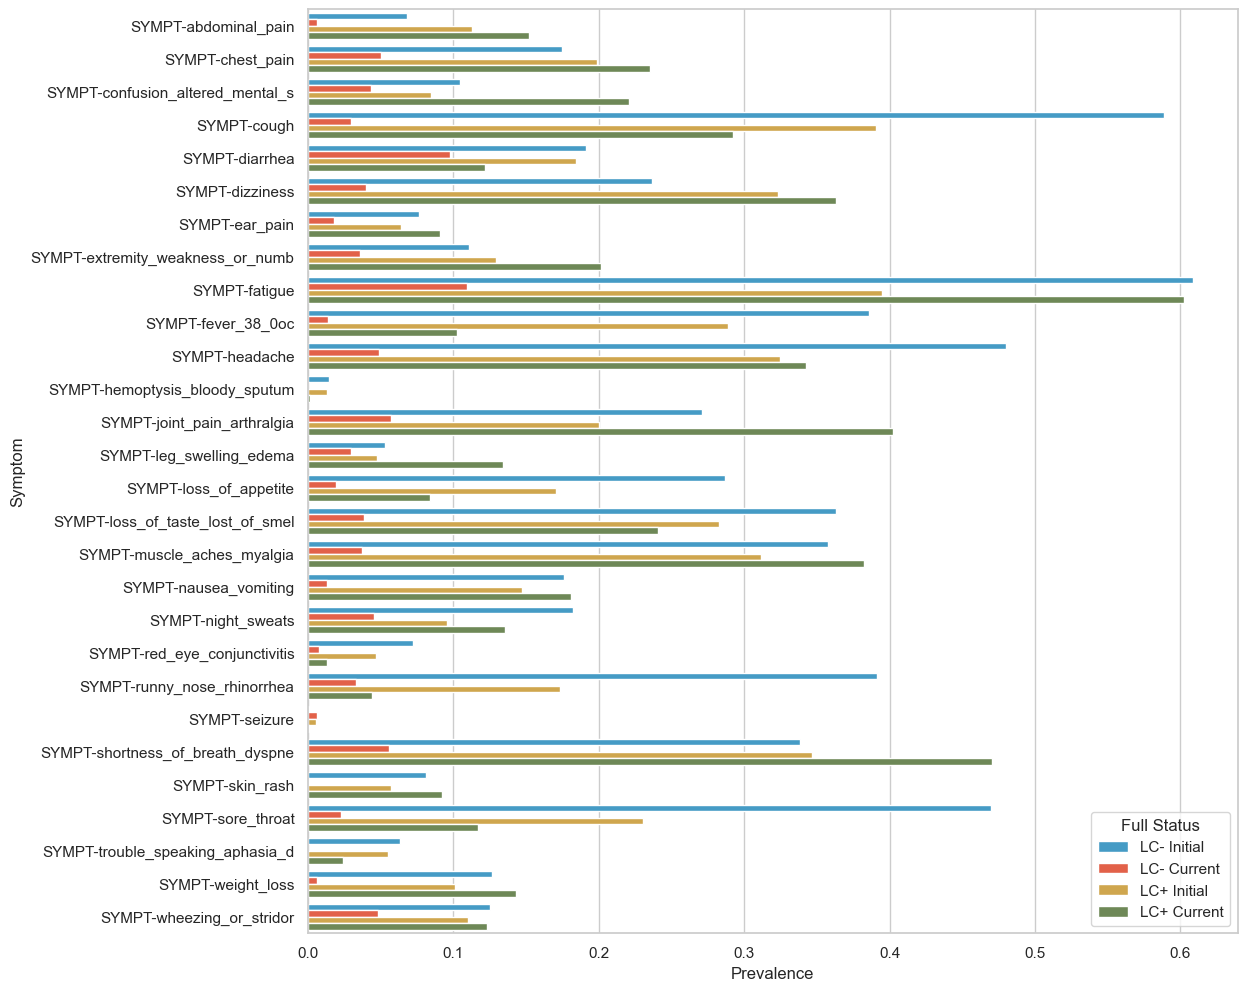

In [140]:
# make a bar chart for each symtpom, segmented by LC_STATUS


fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data = qq, y = "Symptom", x = "Prevalence", hue = "Full Status", 
            hue_order = ['LC- Initial', 'LC- Current', 'LC+ Initial', 'LC+ Current'],
            ax = ax, palette = cc.glasbey_hv, errorbar = None)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/16445135.py:12: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.barplot(data = qq_bin, y = "Symptom", x = "Prevalence", hue = "Full Status",
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/16445135.py:12: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.barplot(data = qq_bin, y = "Symptom", x = "Prevalence", hue = "Full Status",
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/16445135.py:12: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.barplot(data = qq_bin, y = "Symptom", x = "Prevalence", hue = "Full Status",
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_40422/16445135.py:12: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.barplot(data = qq_bin, y = "Symptom",

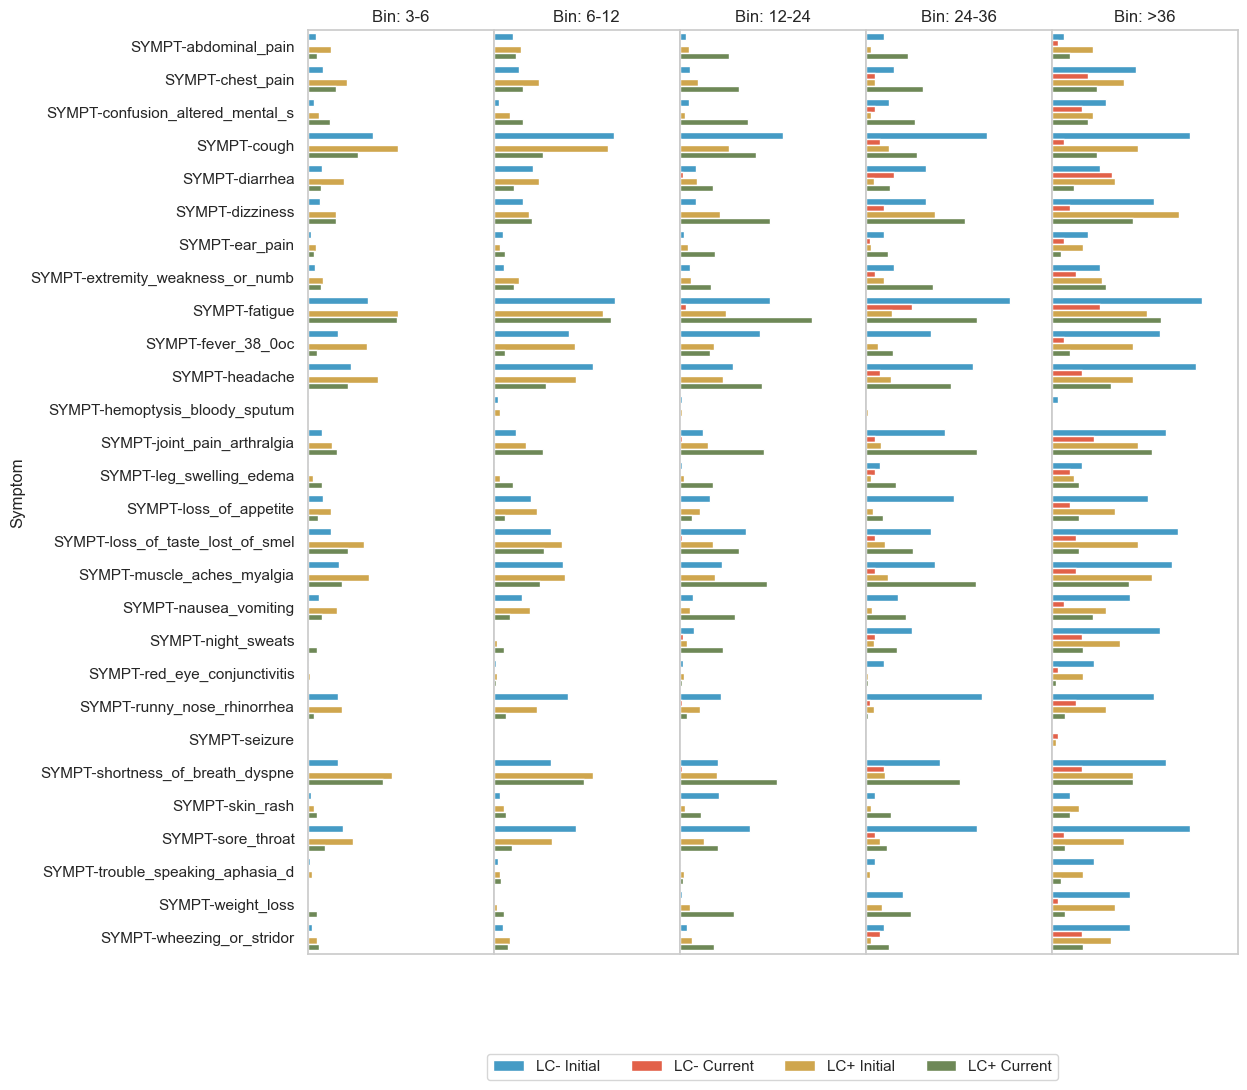

In [141]:
# make a series of subplots for each time bin

fig, ax = plt.subplots(1, 5, figsize=(12, 12), sharex = True, sharey = True)

# squeez the subplots together
plt.subplots_adjust(wspace = 0.0)

for i, bin_label in enumerate(qq.Bin_Labels.unique()):

    qq_bin = qq[qq.Bin_Labels == bin_label]

    sns.barplot(data = qq_bin, y = "Symptom", x = "Prevalence", hue = "Full Status", 
            hue_order = ['LC- Initial', 'LC- Current', 'LC+ Initial', 'LC+ Current'],
            ax = ax[i], palette = cc.glasbey_hv, errorbar = None,
            legend = True)
    # set the xlim to 0, 1
    ax[i].set_xlim(0, 1)

    ax[i].set_title(f"Bin: {bin_label}")

    # remove the legend
    ax[i].get_legend().remove()

    # hide the x axis label
    ax[i].set_xlabel("")

    # hide xticks
    ax[i].set_xticks([])

# 

# add legend blow the full plot
ax[2].legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.1), ncol = 4)